# 1、首先导入包

In [2]:
# 数据科学包
import random                      # 随机切分数据集
import numpy as np                 # 常用数据科学包
import os
from PIL import Image              # 图像读取
import matplotlib.pyplot as plt    # 代码中快速验证
import cv2                         # 图像包

# 深度学习包
import paddle
import paddle.vision.transforms as T       # 数据增强
from paddle.io import Dataset, DataLoader  # 定义数据集

# 2、解压数据集，对数据集进行增广，并创建dataset

In [2]:
# 解压数据集
if not os.path.exists('lego_train'):
    #!unzip data/data10954/cat_12_train.zip
    #!unzip data/data10954/cat_12_test.zip
    !unzip data/data179370/lego.zip

In [3]:
# 按比例随机切割数据集
train_ratio = 0.9  # 训练集占0.9，验证集占0.1

train_paths, train_labels = [], []
valid_paths, valid_labels = [], []
with open('lego_train/train_list.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if random.uniform(0, 1) < train_ratio:
            train_paths.append("lego_train/"+line.split('	')[0])
            label = line.split('	')[1]
            train_labels.append(int(line.split('	')[1]))
        else:
            valid_paths.append("lego_train/"+line.split('	')[0])
            valid_labels.append(int(line.split('	')[1]))

In [8]:
# 定义训练数据集
class TrainData(Dataset):
    def __init__(self):
        super().__init__()
        self.color_jitter = T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
        self.normalize = T.Normalize(mean=0, std=1)
        #self.random_crop = T.RandomCrop(224, pad_if_needed=True)
        self.resize=T.Resize(size=(224,224))
    
    def __getitem__(self, index):
        # 读取图片
        image_path = train_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # C, H, W
        
        # 图像增广
        features = self.color_jitter(image.transpose([1, 2, 0]))
        #features = self.random_crop(features)
        features=self.resize(features)
        features = self.normalize(features.transpose([2, 0, 1])).astype(np.float32)

        # 读取标签
        labels = train_labels[index]

        return features, labels
    
    def __len__(self):
        return len(train_paths)

    
# 定义验证数据集
class ValidData(Dataset):
    def __init__(self):
        super().__init__()
        self.normalize = T.Normalize(mean=0, std=1)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = valid_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # C, H, W
        
        # 图像变换
        features = cv2.resize(image.transpose([1, 2, 0]), (256, 256)).transpose([2, 0, 1]).astype(np.float32)
        features = self.normalize(features)

        # 读取标签
        labels = valid_labels[index]

        return features, labels
    
    def __len__(self):
        return len(valid_paths)

# 3、查看进行的变换，从直觉上判断增广是否合理


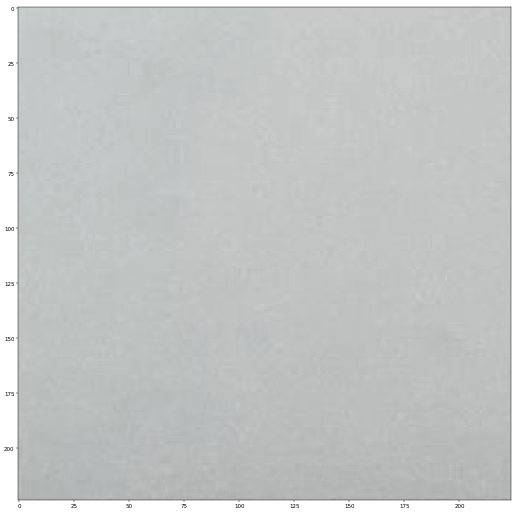

In [9]:
train_data = TrainData()
img, labels = train_data.__getitem__(48)
plt.figure(dpi=40,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))
plt.show()

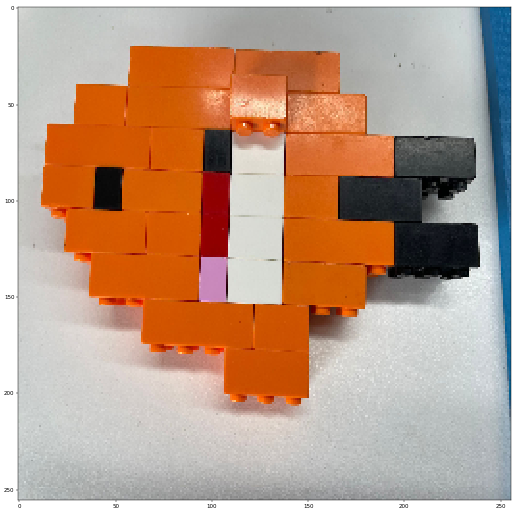

In [10]:
valid_data = ValidData()
img, label = valid_data.__getitem__(14)
plt.figure(dpi=40,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))

# 4、搭建网络模型，进行模型的训练与评估保存

In [ ]:
# 调用resnet50模型
paddle.vision.set_image_backend('cv2')
model = paddle.vision.models.resnet50(pretrained=True, num_classes=6)

# 定义数据迭代器
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=False)

# 定义优化器
opt = paddle.optimizer.Adam(learning_rate=1e-4, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-4))

# 定义损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 设置gpu环境
paddle.set_device('gpu:0')

# 整体训练流程
for epoch_id in range(8):#15
    model.train()
    for batch_id, data in enumerate(train_dataloader()):
        # 读取数据
        features, labels = data
        features = paddle.to_tensor(features)
        labels = paddle.to_tensor(labels)

        # 前向传播
        predicts = model(features)

        # 损失计算
        loss = loss_fn(predicts, labels)

        # 反向传播
        avg_loss = paddle.mean(loss)
        avg_loss.backward()

        # 更新
        opt.step()

        # 清零梯度
        opt.clear_grad()

        # 打印损失
        if batch_id % 2 == 0:
            print('epoch_id:{}, batch_id:{}, loss:{}'.format(epoch_id, batch_id, avg_loss.numpy()))
    model.eval()
    print('开始评估')
    i = 0
    acc = 0
    for image, label in valid_data:
        image = paddle.to_tensor([image])

        pre = list(np.array(model(image)[0]))
        max_item = max(pre)
        pre = pre.index(max_item)

        i += 1
        if pre == label:
            acc += 1
        if i % 10 == 0:
            print('精度：', acc / i)
    
    paddle.save(model.state_dict(), 'acc{}.model'.format(acc / i))

# 5、加载模型进行预测

In [5]:
# 进行预测和提交
# 首先拿到预测文件的路径列表

def listdir(path, list_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        else:
            list_name.append(file_path)
test_path = []
listdir('lego_test', test_path)
    

# 加载训练好的模型
pre_model = paddle.vision.models.resnet50(pretrained=True, num_classes=6)
pre_model.set_state_dict(paddle.load('acc1.0.model'))
pre_model.eval()

pre_classes = []
normalize = T.Normalize(mean=0, std=1)
name=["Aprion_virescens","clownfish","crab","goggles","sea_horse","turtle",'null']
# 生成预测结果
for path in test_path:
    image_path = path

    image = np.array(Image.open(image_path))    # H, W, C
    try:
        image = image.transpose([2, 0, 1])[:3]  # C, H, W
    except:
        image = np.array([image, image, image]) # C, H, W
    
    # 图像变换
    features = cv2.resize(image.transpose([1, 2, 0]), (256, 256)).transpose([2, 0, 1]).astype(np.float32)
    features = normalize(features)

    features = paddle.to_tensor([features])
    pre = list(np.array(pre_model(features)[0]))
    #print(pre)
    max_item = max(pre)
    if max_item<2:
        pre=6
    else:
        pre = pre.index(max_item)
    print("图片：", path, "预测结果：", name[pre])
    pre_classes.append(pre)

print(pre_classes)

图片： lego_test/QQ20221125100301_fli.jpg 预测结果： goggles
图片： lego_test/QQ20221125100304_r180_noise.jpg 预测结果： crab
图片： lego_test/QQ20221125100143_r180_noise.jpg 预测结果： clownfish
图片： lego_test/QQ20221125100131.jpg 预测结果： turtle
图片： lego_test/QQ20221125100314_r180_brighter.jpg 预测结果： sea_horse
图片： lego_test/QQ20221125100311.jpg 预测结果： crab
图片： lego_test/QQ20221125100127_r90_noise.jpg 预测结果： turtle
图片： lego_test/QQ20221125100148_r90.jpg 预测结果： clownfish
图片： lego_test/QQ20221125100246_r90_brighter.jpg 预测结果： Aprion_virescens
图片： lego_test/QQ20221125100319_darker.jpg 预测结果： sea_horse
图片： lego_test/QQ20221125100251_r180_fli.jpg 预测结果： Aprion_virescens
图片： lego_test/QQ20221125100255_r180_darker.jpg 预测结果： goggles
图片： lego_test/.ipynb_checkpoints/1AaCHEuDjBGZinTbJc2o38qL6t9hfe5F-checkpoint.jpg 预测结果： null
图片： lego_test/1AaCHEuDjBGZinTbJc2o38qL6t9hfe5F.jpg 预测结果： null
[3, 2, 1, 5, 4, 2, 5, 1, 0, 4, 0, 3, 6, 6]


In [ ]:
# 导入csv模块
# import csv

# # 1、创建文件对象
# with open('submit.csv', 'w', encoding='gbk', newline="") as f:
#     # 2、基于文件对象构建csv写入对象
#     csv_writer = csv.writer(f)
#     for i in range(240):
#         csv_writer.writerow([test_path[i].split('/')[1], pre_classes[i]])
#     print('写入数据完成')



想要解锁更多技能？B站主页，求关注[一心炼银](https://space.bilibili.com/173706050)